# Kr analysis (run 3575)

In [1]:
from __future__ import print_function, division

import os
import operator
import functools
import textwrap
import copy
import time
import glob
import math
print("Running on ", time.asctime())

import numpy as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import invisible_cities.database.load_db as DB
import invisible_cities.core.system_of_units_c as SystemOfUnits
import invisible_cities.reco.pmaps_functions as pmapf
import invisible_cities.core.fit_functions as fitf

DataPMT = DB.DataPMT()
DataSiPM = DB.DataSiPM()
units = SystemOfUnits.SystemOfUnits()
pi = np.pi


Running on  Wed Apr  5 21:47:37 2017


#### General plotting options

In [2]:
plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

outputfolder = "plots/"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Useful functions

In [3]:
def width(times, to_mus=False):
    """
    Compute peak width.
    """
    w = (np.max(times) - np.min(times)) if np.any(times) else 0.
    return w * units.ns/units.mus if to_mus else w


def timefunc(f):
    """
    Decorator for function timing.
    """
    def time_f(*args, **kwargs):
        t0 = time.time()
        output = f(*args, **kwargs)
        print("Time spent in {}: {} s".format(f.__name__,
                                              time.time() - t0))
        return output
    return time_f


def integrate_charge(d):
    """
    Integrate charge from a SiPM dictionary.
    """
    newd = dict((key, np.sum(value)) for key, value in d.items())
    return map(np.array, list(zip(*newd.items())))


def flat(nested_list):
    while hasattr(nested_list[0], "__iter__"):
        nested_list = [item for inner_list in nested_list for item in inner_list]
    return np.array(nested_list)


def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)


def doublehist(data1, data2, lbls, *args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    h1 = plt.hist(data1, *args, label=lbls[0], alpha=0.5, normed=True, **kwargs)
    h2 = plt.hist(data2, *args, label=lbls[1], alpha=0.5, normed=True, **kwargs)
    return h1, h2, plt.legend()

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def profile_and_scatter(x, y, z, nbin, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, *args, **kwargs)
    x_ = np.repeat(x, x.size)
    y_ = np.tile  (y, y.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.scatter(x_, y_, c=z_, marker="s"), plt.colorbar()


def doublescatter(x1, y1, x2, y2, lbls, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    sc1 = plt.scatter(x1, y1, *args, label=lbls[0], **kwargs)
    sc2 = plt.scatter(x2, y2, *args, label=lbls[1], **kwargs)
    return sc1, sc2, plt.legend()

def covariance(x, y):
    cov = np.cov(x, y)
    l, v = np.linalg.eig(cov)
    lx, ly = l**0.5
    vx, vy = v.T
    x0, y0 = np.mean(x), np.mean(y)
    x1     = lx * vx[0]
    y1     = lx * vx[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*ly, head_length=0.1*lx, fc='r', ec='r')
    x1     = ly * vy[0]
    y1     = ly * vy[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*lx, head_length=0.1*ly, fc='r', ec='r')
    return l, v

def reso(values):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (41.5/2458)**0.5

def gausstext(values):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*f.values[1:], *reso(f.values)))

def save_to_folder(outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)

def load_dst(filename):
    with tb.open_file(filename) as h5:
        return pd.DataFrame.from_records(h5.root.Events.read())

save = functools.partial(save_to_folder, outputfolder)

### Input data

In [8]:
# Comment out this line if your data is in $IC_DATA
ifile = os.path.expandvars("/Users/Gonzalo/github/NEXTdata/Na22/Na22DST.h5")

print("ifile:", ifile)

ifile: /Users/Gonzalo/github/NEXTdata/Na22/Na22DST.h5


# Read data

In [15]:
full = load_dst(ifile)
full.head()

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,2,1.491342e+09,0,1,275.0,64.295494,365.038980,486125.0,41.665438,9505.395508,...,654462.5,49.0,168.3375,168337.5,-30.902690,53.909130,62.138318,2.091304,41.113927,58.683844
1,4,1.491342e+09,0,1,200.0,36.470367,194.114036,531950.0,23.402500,9115.522461,...,661462.5,27.0,129.5125,129512.5,57.252296,0.689844,57.256452,0.012049,12.112382,52.490100
2,6,1.491342e+09,0,1,225.0,49.535275,273.186763,504150.0,30.916812,9145.306641,...,665462.5,43.0,161.3125,161312.5,-80.515359,8.131453,80.924926,3.040941,20.215411,13.245800
3,8,1.491342e+09,0,1,200.0,35.185417,195.103758,517600.0,29.096375,9989.318359,...,654862.5,22.0,137.2625,137262.5,72.665855,68.384014,99.783264,0.755051,13.088289,22.880939
4,12,1.491342e+09,0,1,175.0,34.424568,179.909183,617450.0,39.079687,20055.962891,...,656412.5,50.0,38.9625,38962.5,79.846011,-0.266283,79.846455,-0.003335,12.658441,19.831387


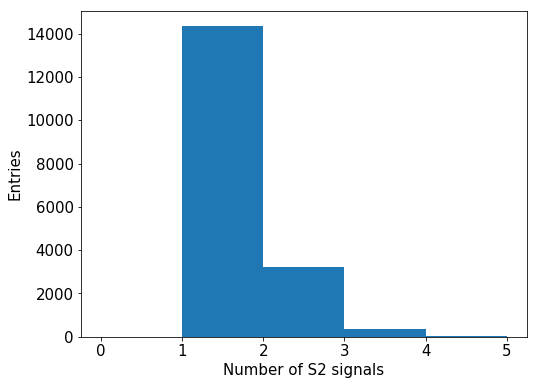

In [31]:
hist(full.nS2, 5, (0,5))
labels("Number of S2 signals", "Entries")

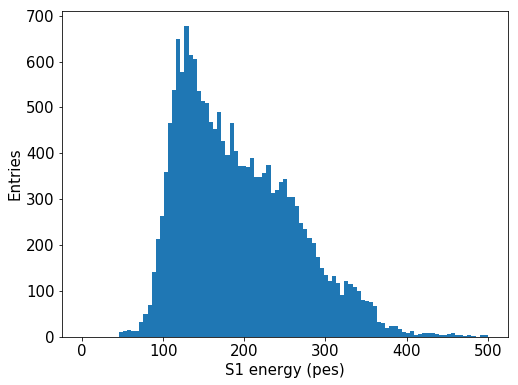

In [33]:
bins = np.linspace(0, 500, 100)
hist(full.S1e, bins)
labels("S1 energy (pes)", "Entries")

bins = np.linspace(0, 500, 21)
hist(full.S1w, bins)
labels("S1 width (ns)", "Entries")

bins = np.linspace(0, 500, 100)
hist(full.S1h, bins)
labels("S1 energy (pes)", "Entries")

bins = np.linspace(0, 500, 100)
hist(full.S1e, bins)
labels("S1 energy (pes)", "Entries")

bins = np.linspace(0, 500, 100)
hist(full.S1e, bins)
labels("S1 energy (pes)", "Entries")

In [27]:
xrays = full[full.nS2 == 2]

# Distribution of events in Z

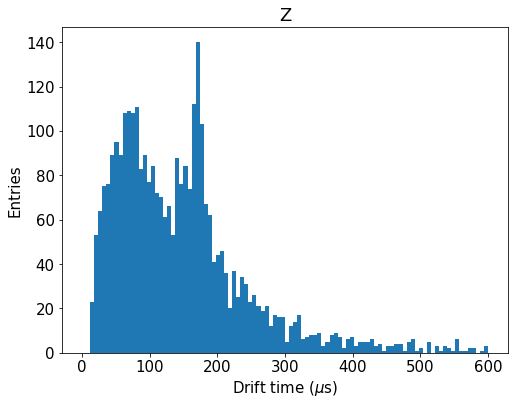

In [28]:
hist(xrays.Z * 1e-3, 100, (0, 600))
labels("Drift time ($\mu$s)", "Entries")
save("Z")

<b>
Looks like there is an accumulation of events for Z < 200 $\mu$s and a flat distribution for Z > 200 $\mu$s.
</b>

# S2 energy vs Z

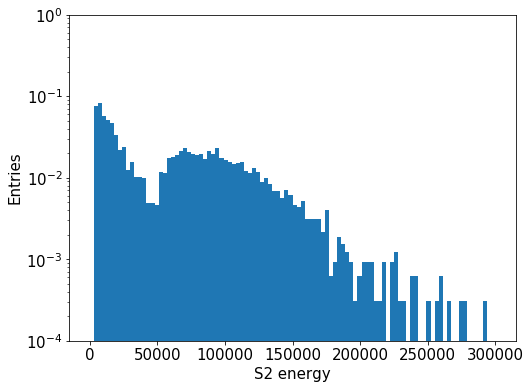

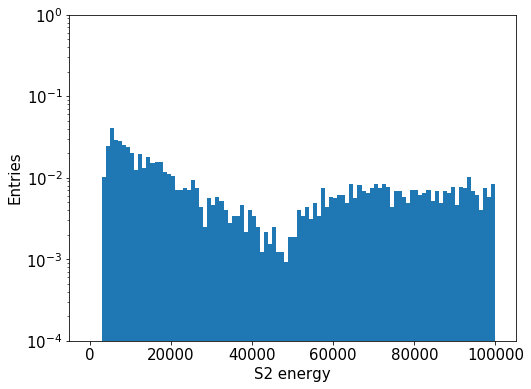

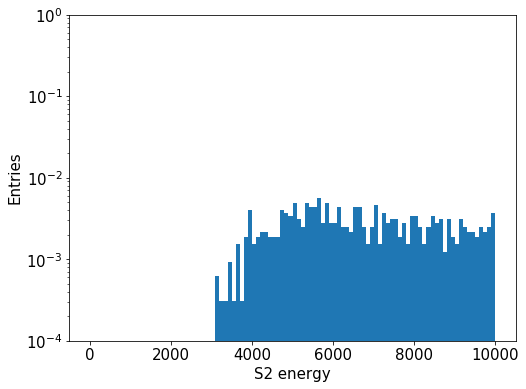

In [29]:
Erange = 0, 3e5
pdf(xrays.S2e, 100, range=Erange)
labels("S2 energy", "Entries")

Erange = 0, 1e5
pdf(xrays.S2e, 100, range=Erange)
labels("S2 energy", "Entries")

Erange = 0, 1e4
pdf(xrays.S2e, 100, range=Erange)
labels("S2 energy", "Entries")

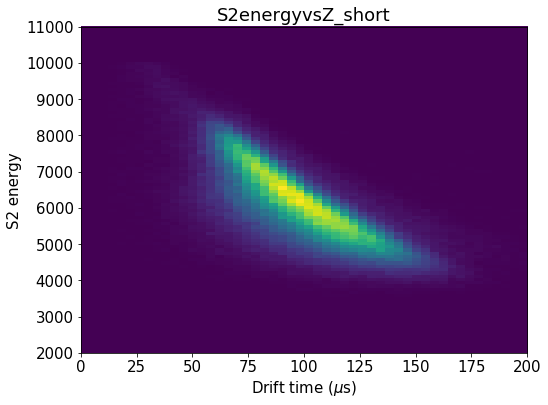

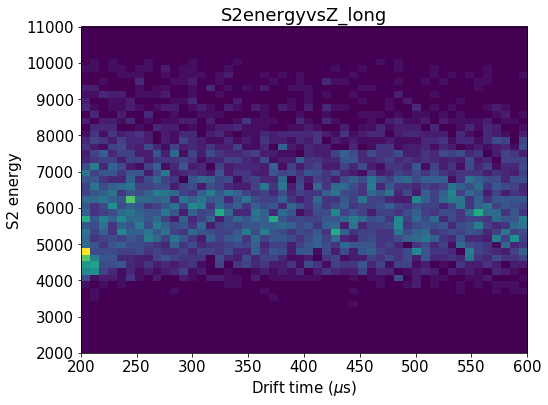

In [12]:
zrange =   0, 200
Erange = 2e3, 11e3
hist2d(full.Z, full.S2e, (50, 100), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")
save("S2energyvsZ_short")

zrange = 200, 600
Erange = 2e3, 11e3
hist2d(full.Z, full.S2e, (50,  50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")
save("S2energyvsZ_long")

# Short drift time: Z < 200 $\mu$s

In [16]:
shortZ = full[full.Z < 200]
print("Ratio:", len(shortZ)/len(full))
shortZ.head()

Ratio: 0.9766786962167902


,event,time,S1w,S1h,S1e,S1t,S2w,S2h,S2e,S2q,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,10,1.490299e+09,125.0,2.001530,8.578108,526500.0,7850.0000,1760.124390,6396.546491,153.725139,653187.5,3.0,126.6875,126.6875,121.761582,27.240410,124.771483,0.220095,4.694699,4.18312
1,12,1.490299e+09,300.0,1.333540,9.487766,492175.0,8207.3125,1114.189697,4470.354279,85.080237,652712.5,2.0,160.5375,160.5375,-110.719067,35.000000,116.119386,2.835417,4.977362,0.00000
2,14,1.490299e+09,75.0,1.316907,4.485979,576350.0,6079.5625,1886.400269,6047.124893,135.024890,652537.5,2.0,76.1875,76.1875,-175.000000,-59.651885,184.887391,-2.813076,0.000000,5.00644
3,18,1.490299e+09,175.0,2.950729,13.514517,587900.0,5989.8125,2827.022949,8999.430527,280.361558,652412.5,4.0,64.5125,64.5125,-15.027502,-46.712307,49.070005,-1.882044,6.028039,3.77384
4,24,1.490299e+09,75.0,1.287624,4.242220,504525.0,8008.1875,1226.703369,5021.740004,81.037123,652837.5,2.0,148.3125,148.3125,0.927833,5.000000,5.085359,1.387317,4.943756,0.00000


# S1 energy

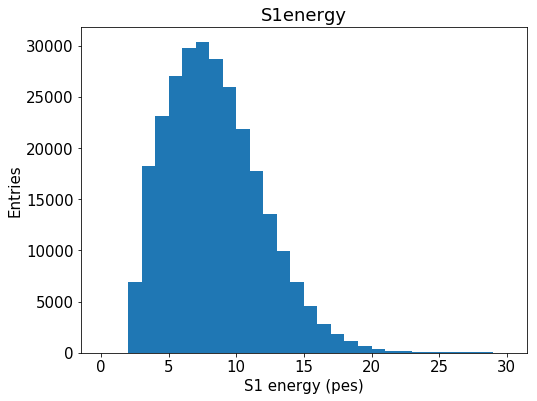

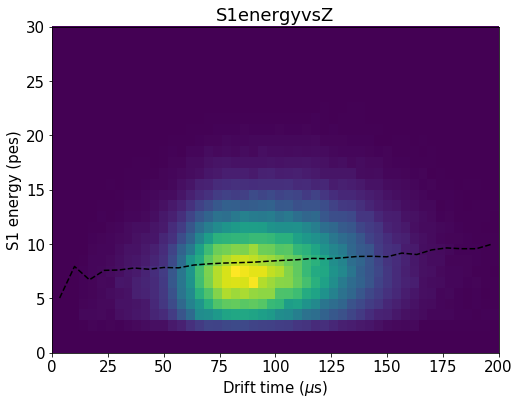

In [19]:
zrange = 0, 200
Srange = 0, 30

hist(shortZ.S1e, 30, range=Srange)
labels("S1 energy (pes)", "Entries")
save("S1energy")

hist2d(shortZ.Z, shortZ.S1e, (50, 30), range=(zrange, Srange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S1e, 30, xrange=zrange, yrange=Srange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 energy (pes)")
save("S1energyvsZ")

# S1 width

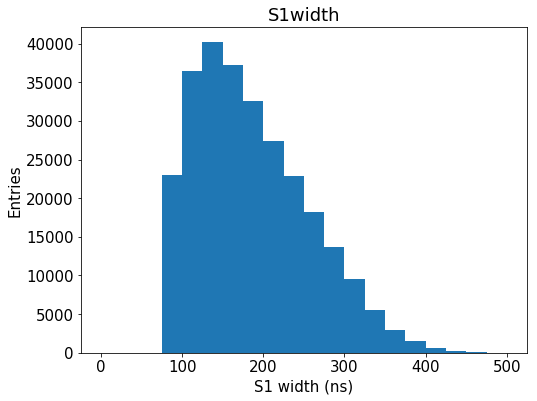

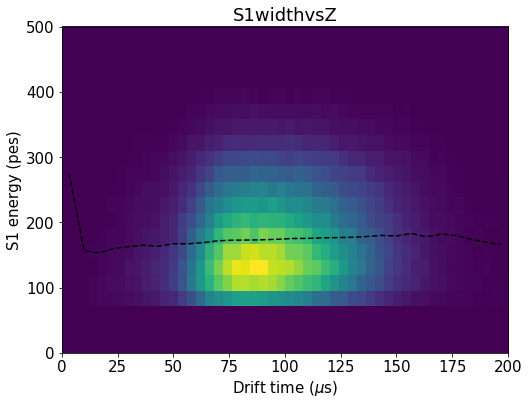

In [20]:
zrange = 0, 200
wrange = 0, 500

hist(shortZ.S1w, np.linspace(*wrange, 21))
labels("S1 width (ns)", "Entries")
save("S1width")

hist2d(shortZ.Z, shortZ.S1w, (50, 21), range=(zrange, wrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S1w, 30, xrange=zrange, yrange=wrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 energy (pes)")
save("S1widthvsZ")

# S1 height

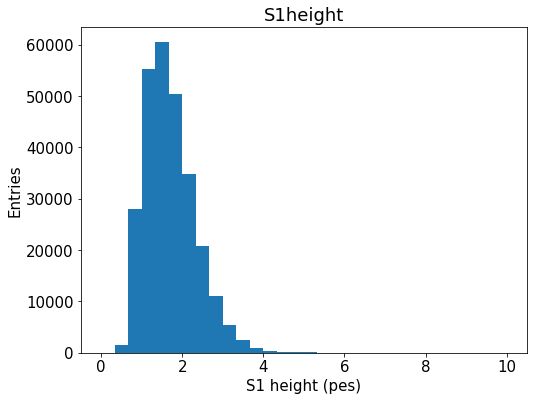

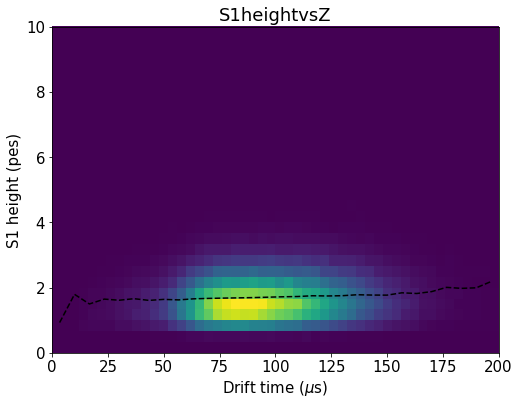

In [21]:
zrange = 0, 200
hrange = 0, 10

hist(shortZ.S1h, 30, range=hrange)
labels("S1 height (pes)", "Entries")
save("S1height")

hist2d(shortZ.Z, shortZ.S1h, (50, 30), range=(zrange, hrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S1h, 30, xrange=zrange, yrange=hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 height (pes)")
save("S1heightvsZ")

# S1 peak to area ratio

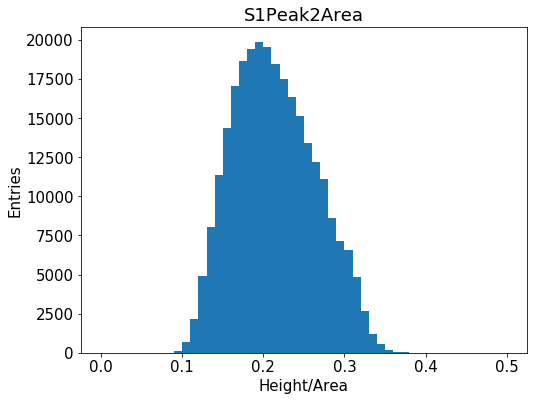

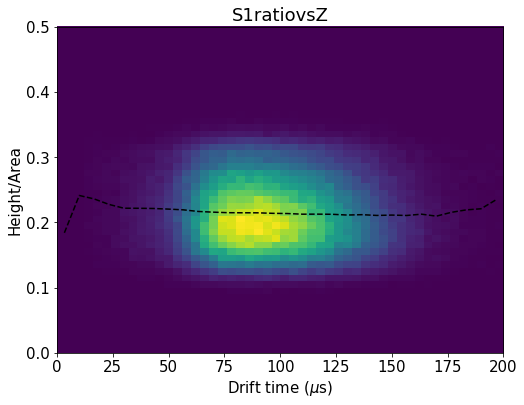

In [30]:
zrange = 0, 200
rrange = 0, 0.5

S1r = shortZ.S1h/shortZ.S1e
hist(S1r, 50, range=rrange)
labels("Height/Area", "Entries")
save("S1Peak2Area")

hist2d(shortZ.Z, S1r, (50, 50), range=(zrange, rrange))
x, y, _ = fitf.profileX(shortZ.Z, S1r, 30, xrange=zrange, yrange=rrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area")
save("S1ratiovsZ")

# S2 energy

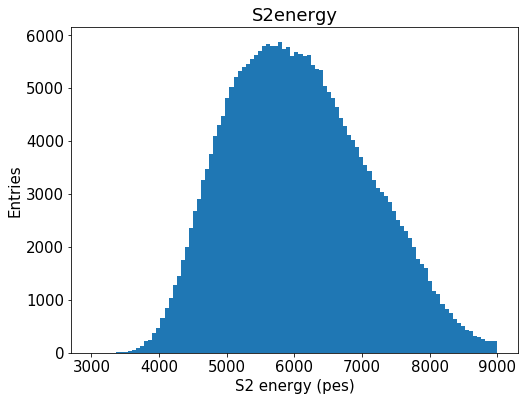

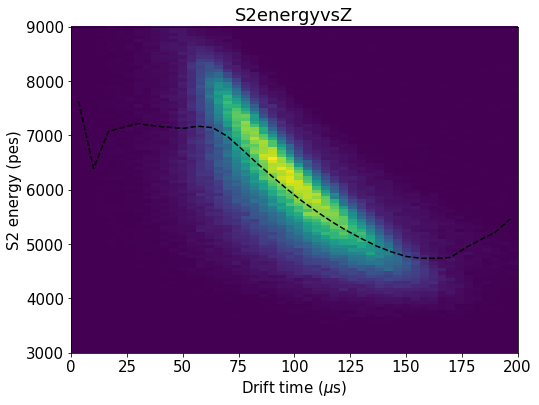

In [31]:
zrange = 0, 200
Erange = 3e3, 9e3

hist(shortZ.S2e, 100, range=Erange)
labels("S2 energy (pes)", "Entries")
save("S2energy")

hist2d(shortZ.Z, shortZ.S2e, (50, 100), range=(zrange, Erange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2e, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ")

# S2 width

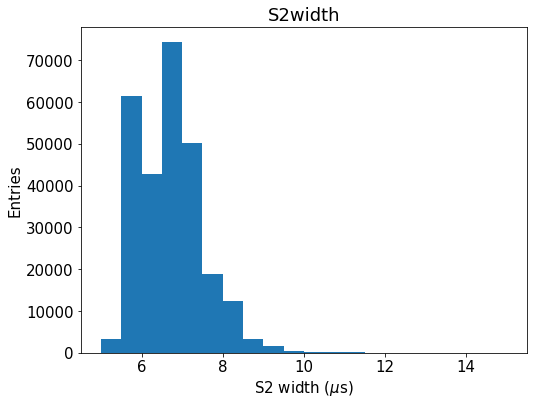

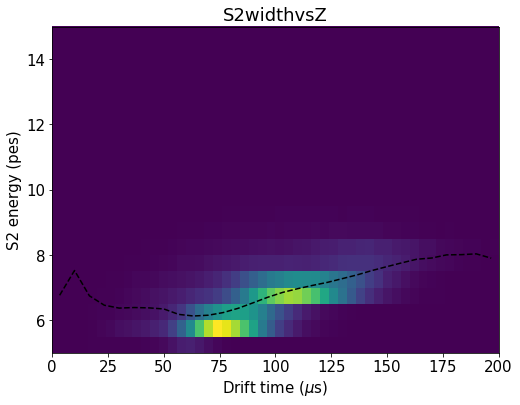

In [32]:
zrange = 0, 200
wrange = 5, 15

hist(shortZ.S2w*1e-3, 20, range=wrange)
labels("S2 width ($\mu$s)", "Entries")
save("S2width")

hist2d(shortZ.Z, shortZ.S2w*1e-3, (50, 20), range=(zrange, wrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2w*1e-3, 30, xrange=zrange, yrange=wrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2widthvsZ")

# S2 height

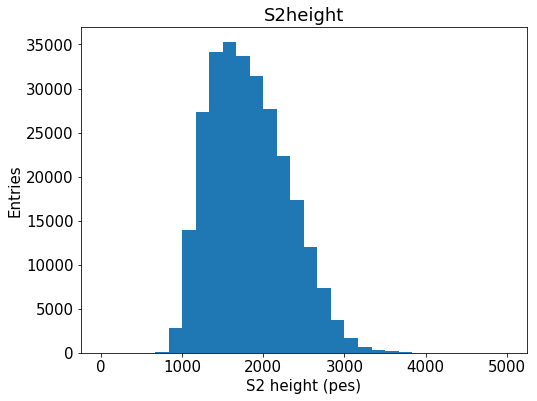

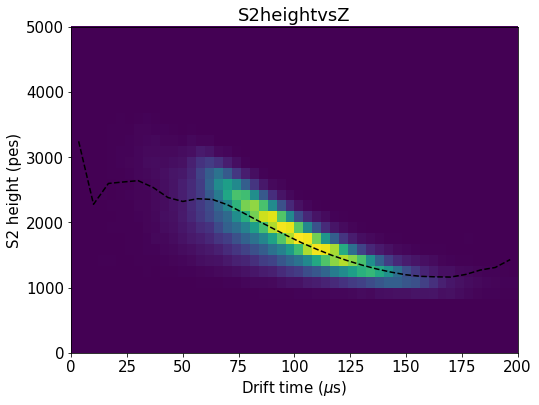

In [33]:
zrange = 0, 200
hrange = 0, 5e3

hist(shortZ.S2h, 30, range=hrange)
labels("S2 height (pes)", "Entries")
save("S2height")

hist2d(shortZ.Z, shortZ.S2h, (50, 30), range=(zrange, hrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2h, 30, xrange=zrange, yrange=hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 height (pes)")
save("S2heightvsZ")

# S2 peak to area ratio

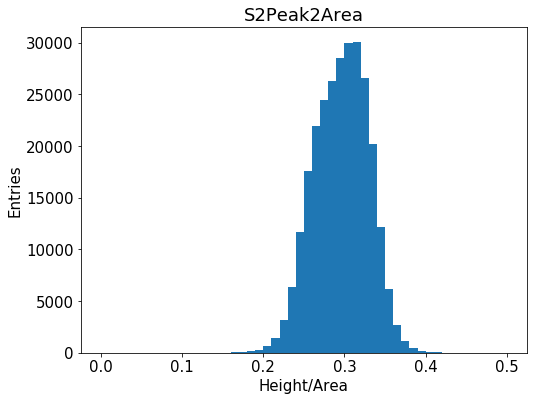

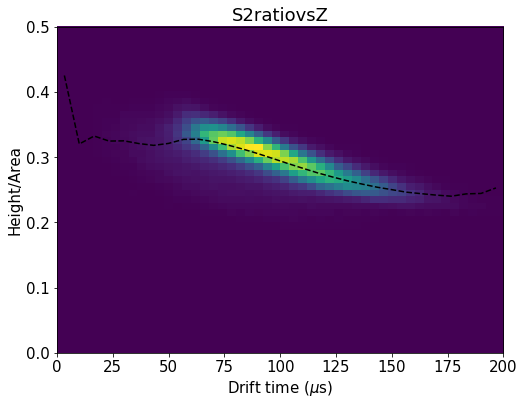

In [34]:
zrange = 0, 200
rrange = 0, 0.5

S2r = shortZ.S2h/shortZ.S2e

hist(S2r, 50, range=rrange)
labels("Height/Area", "Entries")
save("S2Peak2Area")

hist2d(shortZ.Z, S2r, (50, 50), range=(zrange, rrange))
x, y, _ = fitf.profileX(shortZ.Z, S2r, 30, xrange=zrange, yrange=rrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area")
save("S2ratiovsZ")

# S2 vs S1

[  1.17118007e+01   1.05041349e+06] [[ -9.99999981e-01   1.95835738e-04]
 [ -1.95835738e-04  -9.99999981e-01]]


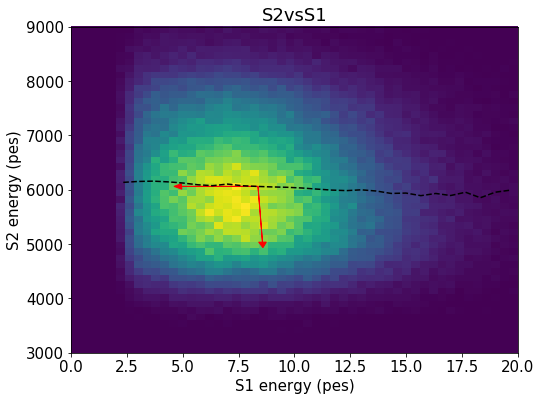

In [35]:
Srange = 0, 20
Erange = 3e3, 9e3

S = shortZ.S1e
E = shortZ.S2e

hist2d(S, E, (50, 50), range=(Srange, Erange))
x, y, _ = fitf.profileX(S, E, 30, xrange=Srange, yrange=Erange)
plt.plot(x, y, profOpt)

sel = fitf.in_range(S, *Srange) & fitf.in_range(E, *Erange)
c = covariance(S[sel], E[sel])
print(*c)
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1")

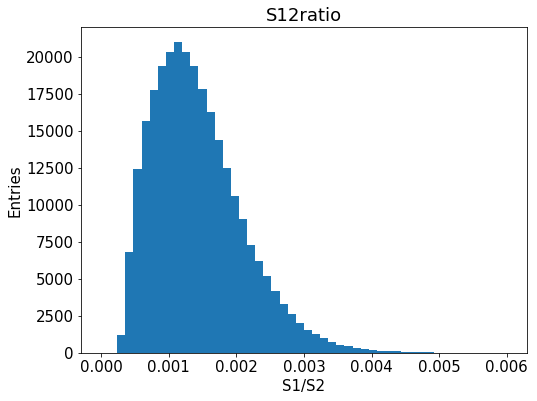

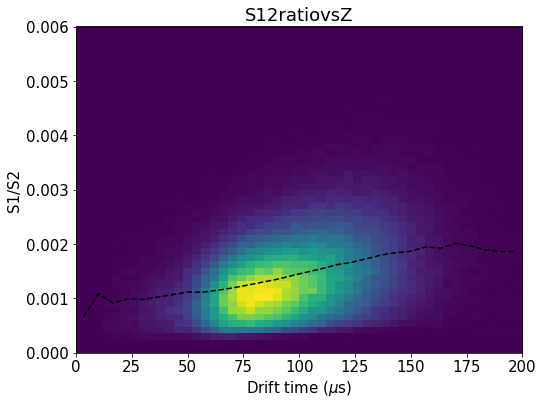

In [36]:
zrange = 0, 200
Rrange = 0, 0.006

S12r = shortZ.S1e/shortZ.S2e

hist(S12r, 50, range=Rrange)
labels("S1/S2", "Entries")
save("S12ratio")

hist2d(shortZ.Z, S12r, (50, 50), range=(zrange, Rrange))
x, y, _ = fitf.profileX(shortZ.Z, S12r, 30, xrange=zrange, yrange=Rrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1/S2")
save("S12ratiovsZ")

# Temporary fiducialization

In [39]:
shortZfid = shortZ[shortZ.R < 100]
print("Ratio:", len(shortZfid)/len(full))
print("Ratio:", len(shortZfid)/len(shortZ))
shortZfid.head()

Ratio: 0.282427768889144
Ratio: 0.2891716282776935


,event,time,S1w,S1h,S1e,S1t,S2w,S2h,S2e,S2q,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
3,18,1.490299e+09,175.0,2.950729,13.514517,587900.0,5989.8125,2827.022949,8999.430527,280.361558,652412.5,4.0,64.5125,64.5125,-15.027502,-46.712307,49.070005,-1.882044,6.028039,3.773840
4,24,1.490299e+09,75.0,1.287624,4.242220,504525.0,8008.1875,1226.703369,5021.740004,81.037123,652837.5,2.0,148.3125,148.3125,0.927833,5.000000,5.085359,1.387317,4.943756,0.000000
5,26,1.490299e+09,125.0,3.112976,13.322994,574825.0,6913.7500,2746.293213,7757.474937,219.904078,652787.5,3.0,77.9625,77.9625,27.036785,77.408401,81.994197,1.234768,4.036515,4.285690
8,34,1.490299e+09,200.0,3.020763,16.845302,570175.0,5987.0625,2469.142822,8058.729324,240.358805,652737.5,4.0,82.5625,82.5625,21.893681,-29.416895,36.669974,-0.930982,4.637180,4.976245
9,36,1.490299e+09,275.0,2.103972,12.398172,548925.0,6875.0000,1795.724365,6398.611130,124.159532,653337.5,2.0,104.4125,104.4125,-65.000000,0.367701,65.001040,3.135936,0.000000,5.006664


# S2 energy fiducialized

[ 11481.81226065   -168.22538113]


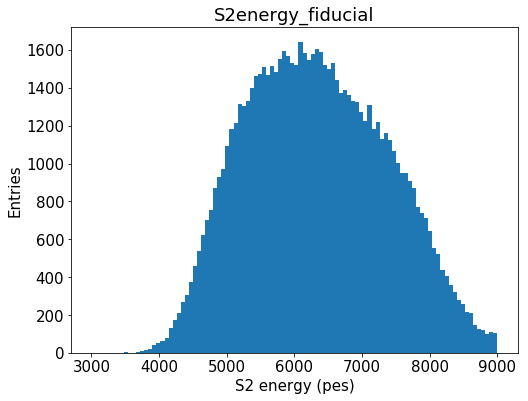

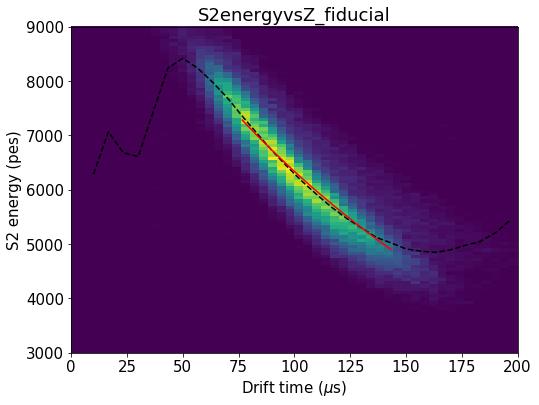

In [40]:
zrange = 0, 200
Erange = 3e3, 9e3

hist(shortZfid.S2e, 100, range=Erange)
labels("S2 energy (pes)", "Entries")
save("S2energy_fiducial")

hist2d(shortZfid.Z, shortZfid.S2e, (50, 100), range=(zrange, Erange))
x, y, _ = fitf.profileX(shortZfid.Z, shortZfid.S2e, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

sel  = fitf.in_range(x, 75, 150)
x, y = x[sel], y[sel]

f = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ_fiducial")

zfun  = f.fn
zmin  = np.min(x)
zcorr = lambda z: zfun(zmin)/zfun(z)

# Correction by attachment

[  7307.690893   -17700.49805613]


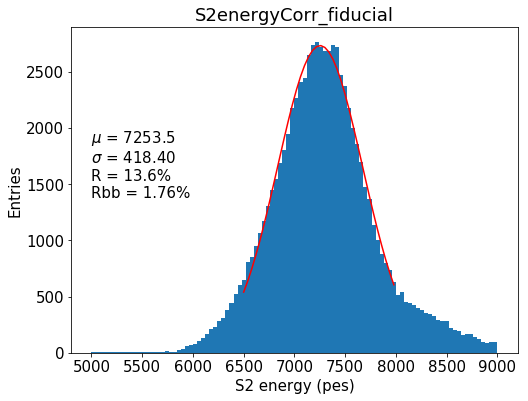

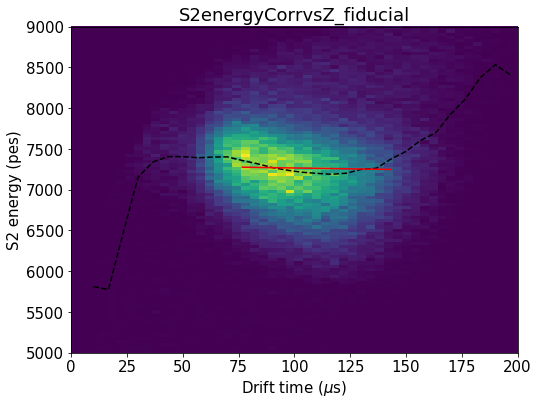

In [41]:
zrange = 0, 200
Erange = 5e3, 9e3

E = shortZfid.S2e * zcorr(shortZfid.Z)

y, x, _ = hist(E, 100, range=Erange)

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 6500, 8000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 7e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("S2 energy (pes)", "Entries")
save("S2energyCorr_fiducial")

hist2d(shortZfid.Z, E, (50, 100), range=(zrange, Erange))
x, y, _ = fitf.profileX(shortZfid.Z, E, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

sel  = fitf.in_range(x, 75, 150)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.plot(x, f.fn(x), fitOpt)

print(f.values)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyCorrvsZ_fiducial")

# Tracking

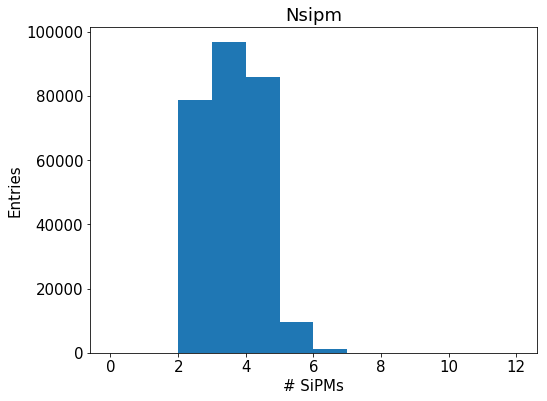

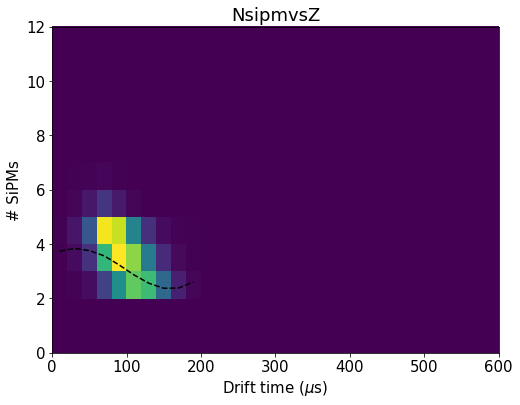

In [42]:
nrange = 0, 12
zrange = 0, 600

hist(shortZ.Nsipm, max(nrange), nrange)
labels("# SiPMs", "Entries")
save("Nsipm")

hist2d(shortZ.Z, shortZ.Nsipm, (30, max(nrange)), range=(zrange, nrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.Nsipm, 30, xrange=zrange, yrange=nrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "# SiPMs")
save("NsipmvsZ")


# Event distribution

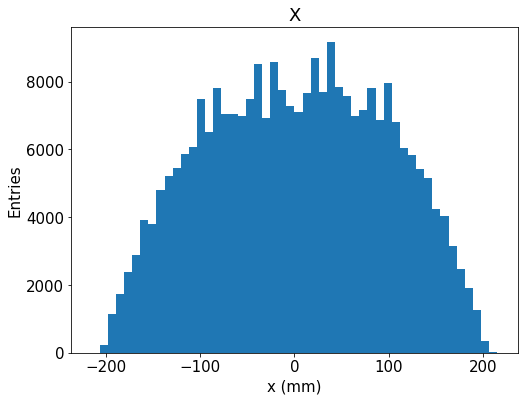

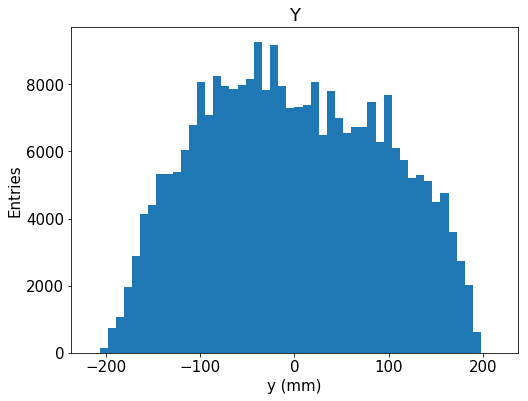

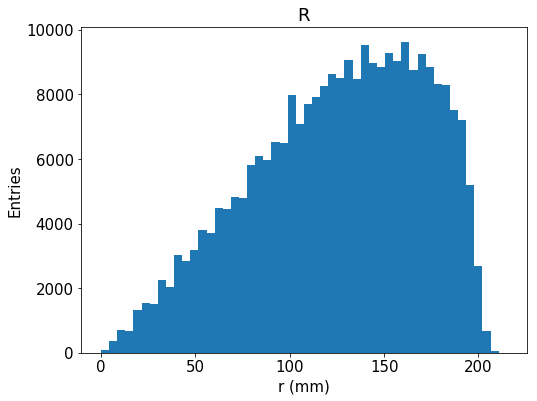

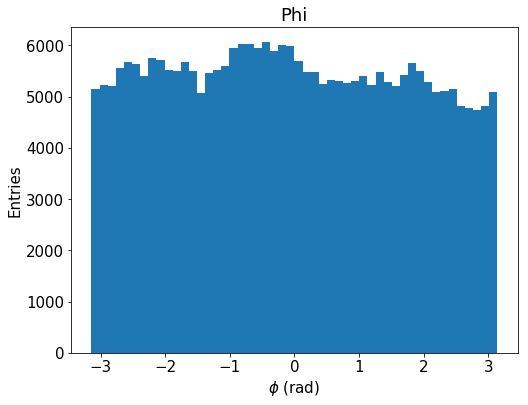

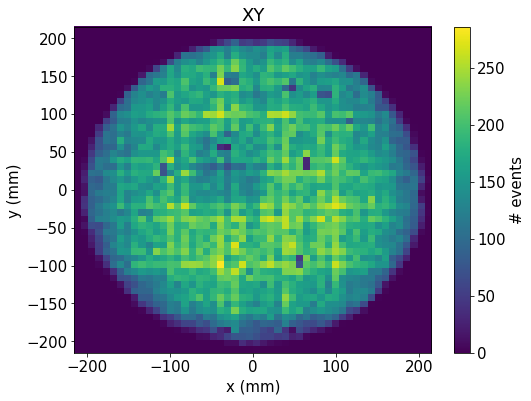

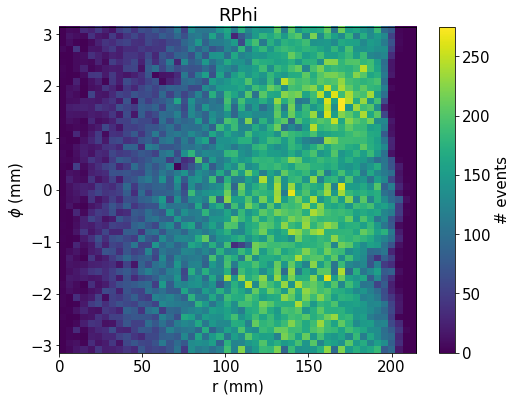

In [43]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi

hist(shortZ.X, 50, range=xrange)
labels("x (mm)", "Entries")
save("X")

hist(shortZ.Y, 50, range=yrange)
labels("y (mm)", "Entries")
save("Y")

hist(shortZ.R, 50, range=rrange)
labels("r (mm)", "Entries")
save("R")

hist(shortZ.Phi, 50, range=prange)
labels("$\phi$ (rad)", "Entries")
save("Phi")

nevts, xs, ys, _ = \
hist2d(shortZ.X, shortZ.Y, (50, 50), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")
save("XY")

################################
hist2d(shortZ.R, shortZ.Phi, (50, 50), range=(rrange, prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)")
save("RPhi")

# Tracking charge

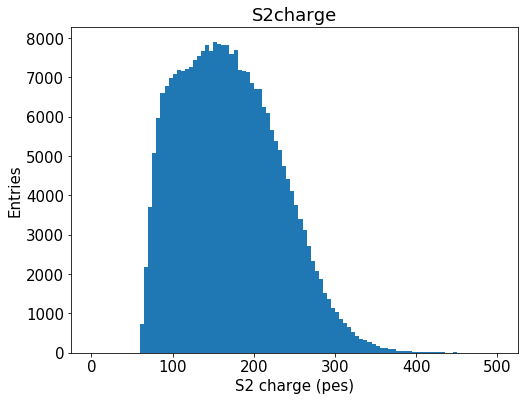

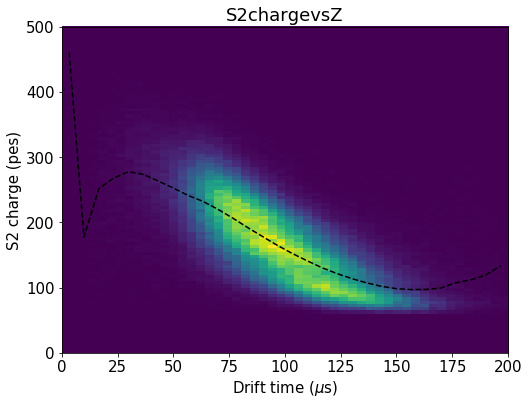

In [44]:
zrange = 0, 200
Qrange = 0, 500

hist(shortZ.S2q, 100, range=Qrange)
labels("S2 charge (pes)", "Entries")
save("S2charge")

hist2d(shortZ.Z, shortZ.S2q, (50, 100), range=(zrange, Qrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2q, 30, xrange=zrange, yrange=Qrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 charge (pes)")
save("S2chargevsZ")

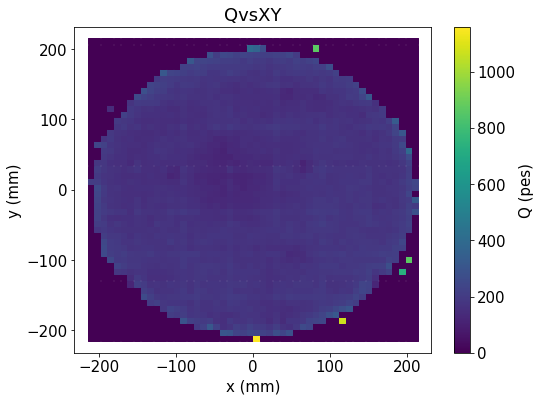

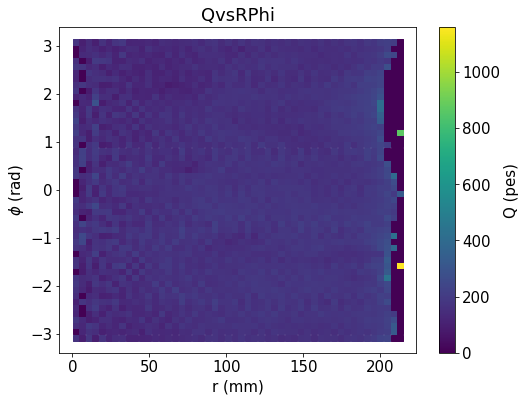

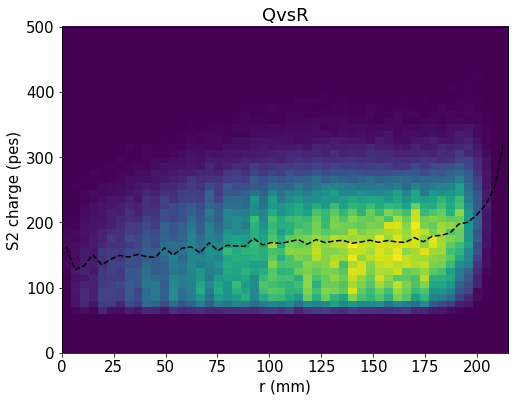

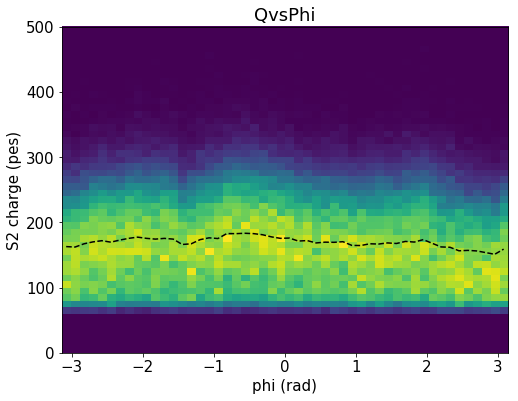

In [45]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Qrange =    0, 500

_, _, cb = profile_and_scatter(shortZ.X, shortZ.Y, shortZ.S2q, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)")
save("QvsXY")

_, _, cb = profile_and_scatter(shortZ.R, shortZ.Phi, shortZ.S2q, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("QvsRPhi")

hist2d(shortZ.R, shortZ.S2q, (50, 50), range=(rrange, Qrange))
x, y, _ = fitf.profileX(shortZ.R, shortZ.S2q, 50, xrange=rrange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 charge (pes)")
save("QvsR")

hist2d(shortZ.Phi, shortZ.S2q, (50, 50), range=(prange, Qrange))
x, y, _ = fitf.profileX(shortZ.Phi, shortZ.S2q, 50, xrange=prange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 charge (pes)")
save("QvsPhi")


# Energy vs position

7149.45959839


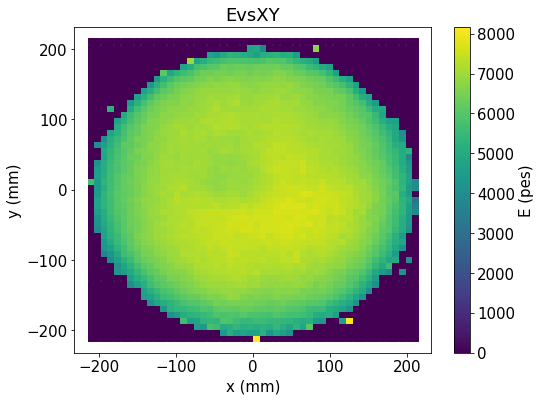

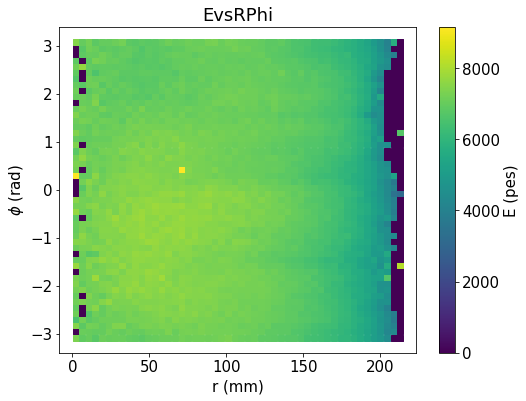

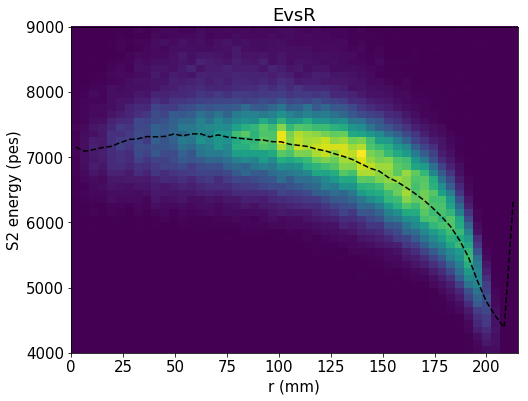

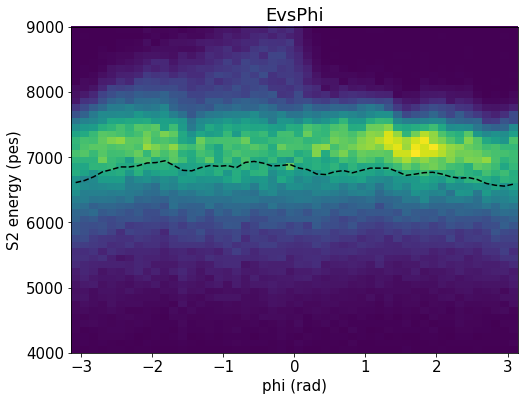

In [47]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 9e3

E = shortZ.S2e * zcorr(shortZ.Z)

pf, _, cb = profile_and_scatter(shortZ.X, shortZ.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(shortZ.R, shortZ.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(shortZ.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(shortZ.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(shortZ.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(shortZ.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])


# Correction by attachment and position

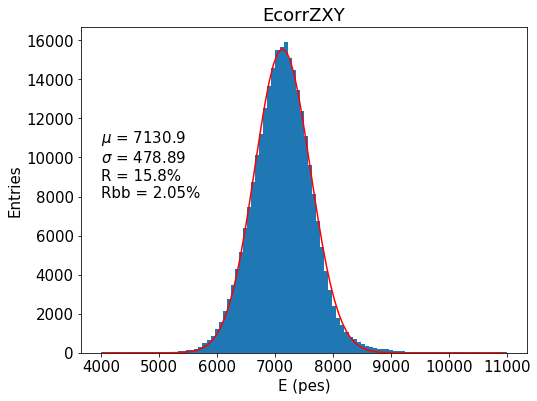

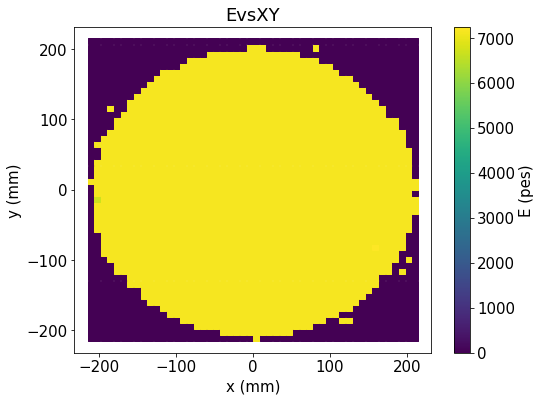

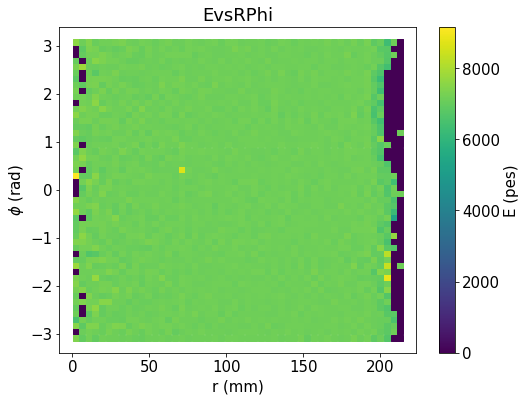

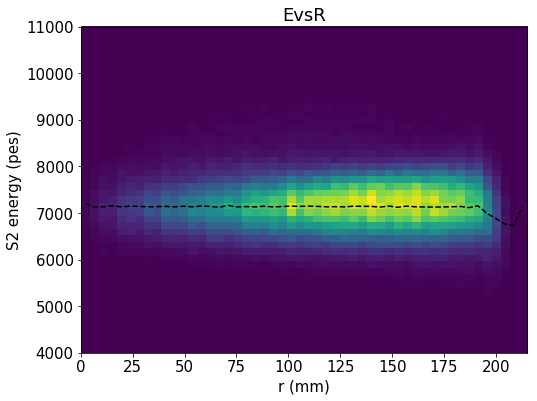

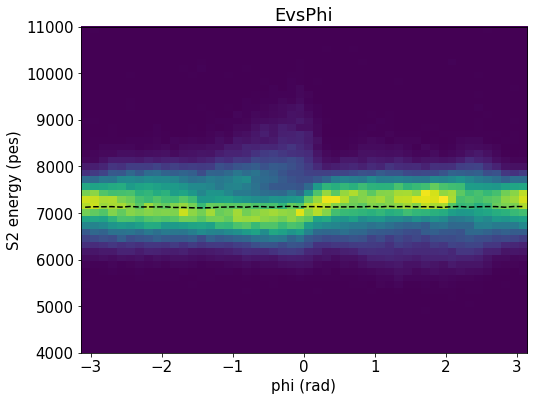

In [49]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 11e3

E  = shortZ.S2e * zcorr(shortZ.Z) * xycorr(shortZ.X.values, shortZ.Y.values)

y, x, _ = hist(E, 100, Erange)

x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 1e4, 1e2))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("E (pes)", "Entries")
save("EcorrZXY")

_, _, cb = profile_and_scatter(shortZ.X, shortZ.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(shortZ.R, shortZ.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(shortZ.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(shortZ.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(shortZ.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(shortZ.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")


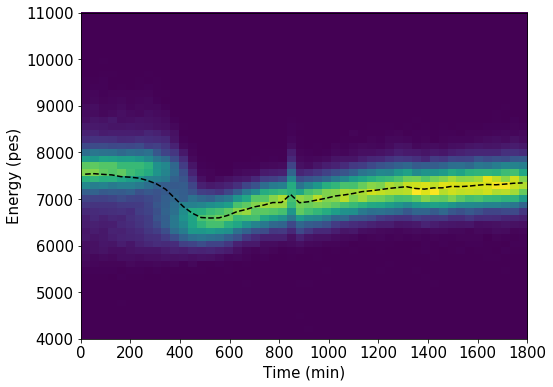

In [55]:
E = shortZ.S2e * zcorr(shortZ.Z) * xycorr(shortZ.X.values, shortZ.Y.values)
T = (shortZ.time - np.min(shortZ.time))/60

Erange = 4e3, 11e3
Trange =   0, 1800

hist2d(T, E, (50, 50), range=(Trange, Erange))

x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")

def get_timecorr(T, E):
    eref = np.max(E)
    def timecorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return timecorr
tcorr = get_timecorr(x, y)

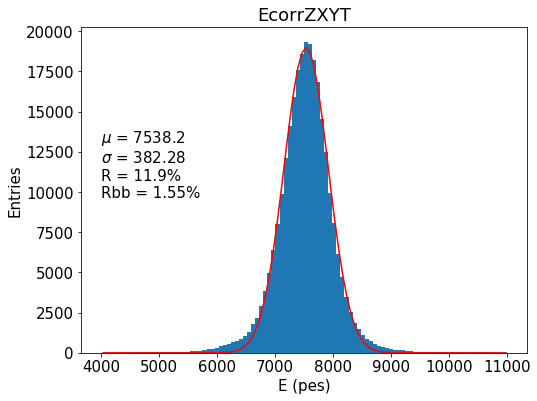

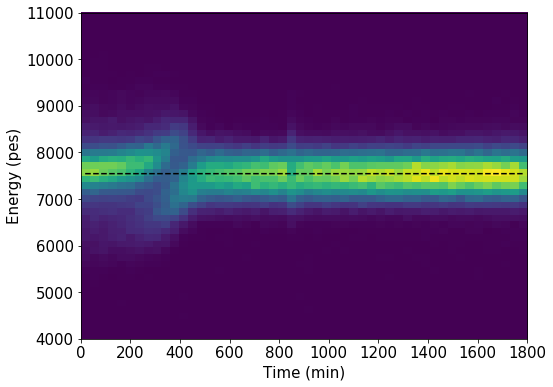

In [58]:
T = (shortZ.time - np.min(shortZ.time))/60
E = shortZ.S2e * zcorr(shortZ.Z) * xycorr(shortZ.X.values, shortZ.Y.values) * tcorr(T)

Trange =   0, 1800
Erange = 4e3, 11e3

y, x, _ = hist(E, 100, Erange)

x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 1e4, 1e2))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("E (pes)", "Entries")
save("EcorrZXYT")

hist2d(T, E, (50, 50), range=(Trange, Erange))
x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")
